# Combinatorial virtual library of novel BRD4 inhibitors 
This workflow generates potentially novel BRD4 inhibitors by attaching readily available amine and alkyne building-blocks to reported BRD4 scaffolds using virtual amidation and Sonogashira coupling reactions. The virtual library is designed to test ML QSAR models. This approach ensures that: 
- all compounds are readily accessible via synthesis
- the set was not biased to give potent inhibitors
- the generated compounds are expected to be within the applicability domain of the QSAR model, as the scaffolds are derived from the training data  

The amide of **CHEMBL3900452** (`IC50 = 2.49 nM`) for example will be formally hydrolyzed and the amine replaced with commercially available amines [(top 50 prim. amines)](https://enamine.net/building-blocks/functional-classes/primary-amines) to form different amides. The chloro-substituted aryl ring on the other hand will be used as substrate for virtual Sonogashira reactions with terminal alkynes [(acetylenes)](https://enamine.net/building-blocks/functional-classes). 

| CHEMBL3900452 | amide | chloro |
| ------------- | ----- | ------ |
| ![substrate](../images/substrate.png) | ![amide](../images/substrate_amide.png) | ![chloro](../images/substrate_chloro.png) | 

Both transformations are known exit vectors for *thienotriazolodiazepines*, but will be applied to all scaffolds bearing the required substructures. 

# Setup Code
## Environment

In [93]:
### use brd4

import sys

print(sys.executable)

/home/oskar/anaconda3/envs/brd4/bin/python


## Imports

In [ ]:
### Standard imports
import copy
import os

import numpy as np
import pandas as pd

### Standard Cheminformatics imports
import rdkit as rd
from rdkit import Chem, RDLogger
from rdkit.Chem import (
    PandasTools,
)

## Jupyter Settings

In [95]:
### Random seed - using the same seed for robustness
SEED = 42
np.random.seed(SEED)

In [ ]:
### NumPy arrays - floats
np.set_printoptions(
    precision=2,  # round values
    suppress=True,
)  # avoid scientific notation

### pandas DataFrames
pd.set_option("display.float_format", "{:.2f}".format)  # Round to 2 decimal places

In [ ]:
### To track progress of slow code
# from tqdm.auto import tqdm
from tqdm import tqdm

tqdm.pandas()  # Initialize tqdm for pandas

In [ ]:
# Suppress RDKit logs
RDLogger.DisableLog("rdApp.*")

# Re-enable logging if needed
# RDLogger.EnableLog('rdApp.*')

## Utils
- `utils/pd_mol.py` contains individual functions for processing rdkit mol objects in pandas DataFrames

In [99]:
### Add the utils directory to the path
sys.path.append(os.path.abspath("../utils"))

import pd_mol
from pd_mol import render_mol
from similarity_sali import MorganSimilarity

## Functions

### Virtual reactions

# Data
To ensure reproducibility `01_brd4_inhibitors_3k.pkl` is used in this analysis. Feel free to use `01_brd4_all_inhibitors.pkl` for a more updated version of the data set. `01_brd4_inhibitors_3k.pkl` contains **2684** unique molecules. They are described by (columns):
- `ID`: string - unique identifier from `ChEMBL`
- `IC50_nM`: float - half maximal inhibitory concentration in `nmol / L`. 
- `active`: float - 1.00 (active), 0.00 (inactive), NaN (no assignment) 
- `Mol`: rdkit.Chem.rdchem.Mol - standardized inhibitor structure 

BRD4 data set with 2684 entries


,IC50_nM,active,Mol
ID,,,
CHEMBL5171062,0.33,1.00,
CHEMBL5171510,0.39,1.00,

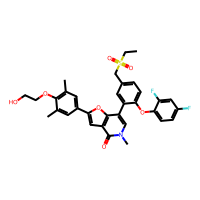
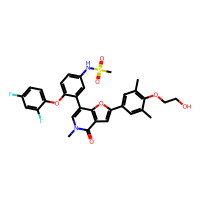

In [ ]:
df = pd.read_pickle("../data/01_brd4_inhibitros_3k.pkl")
df.set_index("ID", inplace=True)
print(f"BRD4 data set with {len(df)} entries")
render_mol(df.head(2))

# Combinatorial Amide Library


## Acids from non-cyclic 2° amide
The crucial point for virtual reactions is the substrate substructure definition:
- [N**H**:1] limits the scope to 2° amides
- **!@** limits the scope to non-cyclic amides
- excluding carbamate- and urea-containing substrates was not required in this data set
- The atoms are numbered to enable atom mapping

SMARTS strings can be plotted as mol objects, but the visualization gives only limited insights.  

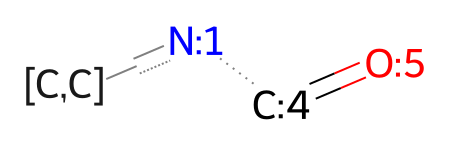

In [ ]:
smarts_2nd_linear_amide = "[c,C:3][NH:1]!@[C:4]=[O:5]"
Chem.MolFromSmarts(smarts_2nd_linear_amide)

The analysis below shows that most inhibitors contain no amide and some contain multiple amide groups. 

In [102]:
pd_mol.count_smarts_matches(df, smarts_2nd_linear_amide).value_counts(dropna=False)

Mol
0    2312
1     327
2      44
3       1
Name: count, dtype: int64

For simplicity only inhibitors containing one amide are considered.  

,IC50_nM,active,Mol
ID,,,
CHEMBL5202705,0.52,1.00,
CHEMBL4095826,2.00,1.00,

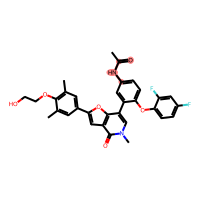
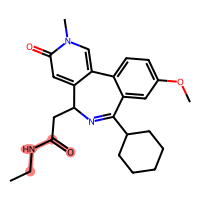

In [ ]:
one_amide_df = render_mol(
    df.loc[pd_mol.count_smarts_matches(df, smarts_2nd_linear_amide) == 1]
)
render_mol(one_amide_df.head(2))

## Cleave 2° non-cyclic amides

100%|██████████| 327/327 [00:00<00:00, 2034.05it/s]
/home/oskar/GitHub/QSAR_BRD4/utils/pd_mol.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"Product_{col}"] = products_df[col]
/home/oskar/GitHub/QSAR_BRD4/utils/pd_mol.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"Product_{col}"] = products_df[col]


,IC50_nM,active,Mol,Product_0,Product_1
ID,,,,,
CHEMBL5202705,0.52,1.00,,,
CHEMBL4095826,2.00,1.00,,,
CHEMBL3932024,2.19,1.00,,,
CHEMBL5190094,2.30,1.00,,,
CHEMBL3900452,2.49,1.00,,,

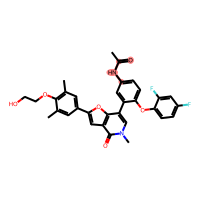
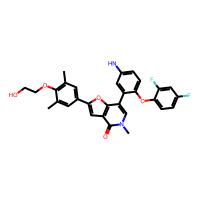
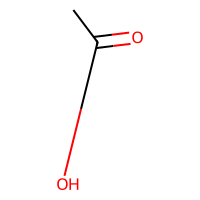
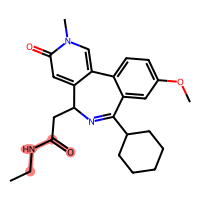
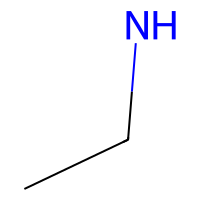
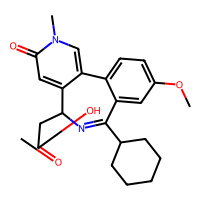
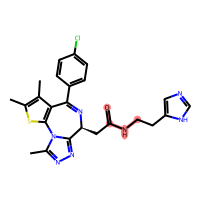
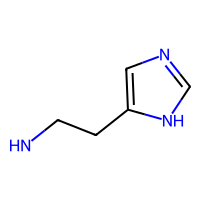
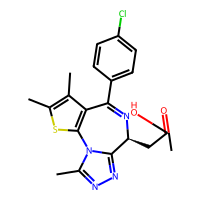
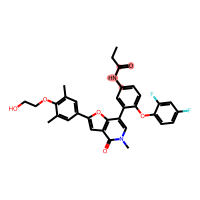
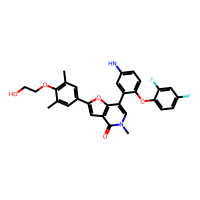
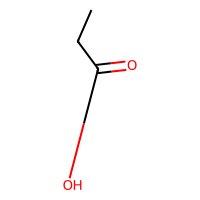
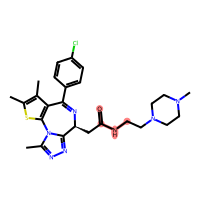
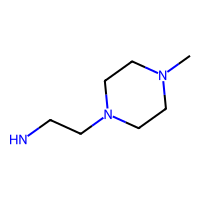
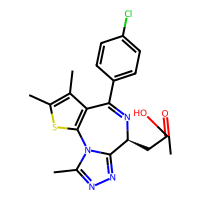

In [ ]:
### Reaction SMARTS for amide hydrolysis
smarts_2nd_linear_amide_hydrolysis = (
    "[c,C:1][NH:2]!@[C:3]=[O:4].[O:5]>>[c,C:1][NH:2].[C:3](=[O:4])[O:5]"
)

### Amide hydrolysis
amide_hydrolysis_df = pd_mol.rxn_2_sms(one_amide_df, smarts_2nd_linear_amide_hydrolysis)
render_mol(amide_hydrolysis_df.head(5))

## Subset for unique acids
**Slice index and product column**

In [ ]:
acids_df = copy.deepcopy(amide_hydrolysis_df[["Product_1"]])

**Structure Standardization**

Overwrites the 'Mol' column with a standardized 'Mol' column

In [ ]:
acids_df["Mol"] = pd_mol.standardize_mol_col(acids_df["Product_1"])

largest_frag=True (rdMolStandardize.FragmentParent):


100%|██████████| 327/327 [00:00<00:00, 393.59it/s]


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 327/327 [00:00<00:00, 9631.11it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 327/327 [00:00<00:00, 611.32it/s]


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=True (rdDepictor.Compute2DCoords):


100%|██████████| 327/327 [00:00<00:00, 1763.62it/s]


cal_2D_coord_deep=False (rdCoordGen.AddCoords):
cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 327/327 [00:00<00:00, 459.30it/s]


**Remove duplicates**

In [ ]:
### Generate standardized SMILES from Mol
acids_df["can_smiles"] = pd_mol.canonical_smiles(acids_df["Mol"])
print("{} duplicated rows found".format(acids_df.duplicated(subset="can_smiles").sum()))

134 duplicated rows found


In [ ]:
### Remove duplicated rows
acids_df = acids_df.drop_duplicates(subset="can_smiles", keep="first")

**Assigne acid IDs**

In [ ]:
acids_df = acids_df.reset_index()
acids_df["acid_ID"] = acids_df.index.map(lambda x: f"acid-{x + 1}")

**Subset for required columns**

193 unique acids


,acid_ID,Mol
0,acid-1,
1,acid-2,
2,acid-3,
3,acid-4,
4,acid-5,

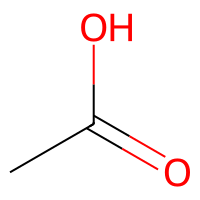
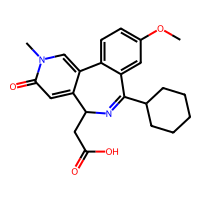
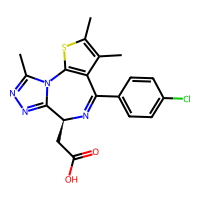
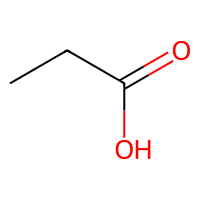
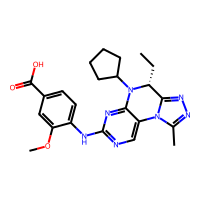

In [ ]:
sm_acids_df = copy.deepcopy(acids_df[["acid_ID", "Mol"]])
print(f"{len(sm_acids_df)} unique acids")
render_mol(sm_acids_df.head(5))

## Amines
**Import from Enamine**

https://enamine.net/building-blocks/functional-classes/primary-amines
top 50 primary amines from Enamine

In [ ]:
amines_df = PandasTools.LoadSDF(
    "../data/Enamine_TOP50_PriAmines_50cmpds_20200703.sdf",
    idName="ID",
    molColName="Mol",
)

**Structure Standardization**

Overwrites/creates the 'Mol' column with a standardized 'Mol' column

In [ ]:
amines_df["Mol"] = pd_mol.standardize_mol_col(amines_df["Mol"])

largest_frag=True (rdMolStandardize.FragmentParent):


100%|██████████| 50/50 [00:00<00:00, 391.33it/s]


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 50/50 [00:00<00:00, 10015.05it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 50/50 [00:00<00:00, 722.92it/s]


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=True (rdDepictor.Compute2DCoords):


100%|██████████| 50/50 [00:00<00:00, 4907.11it/s]


cal_2D_coord_deep=False (rdCoordGen.AddCoords):
cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 50/50 [00:00<00:00, 370.75it/s]


**Assigne amine IDs**

,amine_ID,Mol
0,amine-1,
1,amine-2,
2,amine-3,

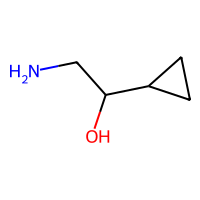
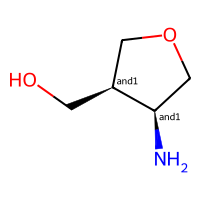
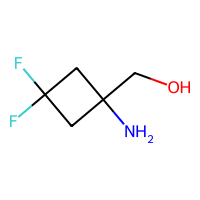

In [ ]:
amines_df["amine_ID"] = amines_df.index.map(lambda x: f"amine-{x + 1}")
sm_amines_df = copy.deepcopy(amines_df[["amine_ID", "Mol"]])
render_mol(sm_amines_df.head(3))

## Combinatorial amide library

50 amines
193 acids
9650 amides


,acid_ID,Mol_acid,amine_ID,Mol_amine
3773,acid-76,,amine-24,
4053,acid-82,,amine-4,
4165,acid-84,,amine-16,

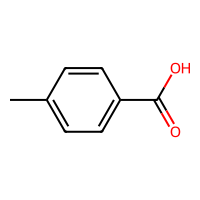
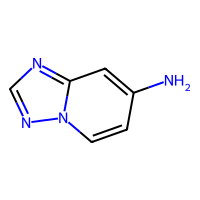
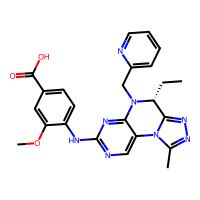
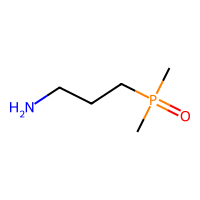
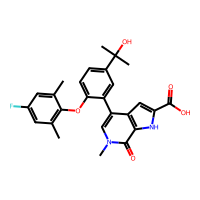
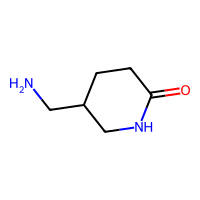

In [ ]:
cross_merge_amides_df = sm_acids_df.merge(
    sm_amines_df, how="cross", suffixes=["_acid", "_amine"]
)

print("{} amines".format(len(sm_amines_df)))
print("{} acids".format(len(sm_acids_df)))
print("{} amides".format(len(cross_merge_amides_df)))
render_mol(cross_merge_amides_df.sample(3))

**Virtual amidation**

 16%|█▋        | 1592/9650 [00:00<00:04, 1671.49it/s]

100%|██████████| 9650/9650 [00:03<00:00, 2665.19it/s]


,acid_ID,Mol_acid,amine_ID,Mol_amine,Product_0,Product_1,ID
7979,acid-160,,amine-30,,,,acid-160_amine-30
4753,acid-96,,amine-4,,,,acid-96_amine-4
1243,acid-25,,amine-44,,,,acid-25_amine-44
8436,acid-169,,amine-37,,,,acid-169_amine-37
2961,acid-60,,amine-12,,,,acid-60_amine-12

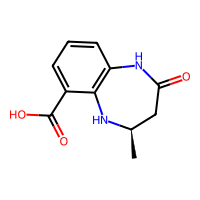
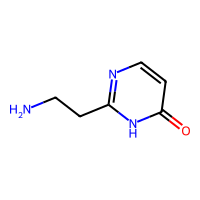
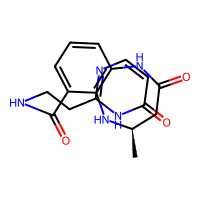
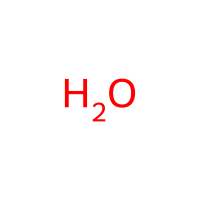
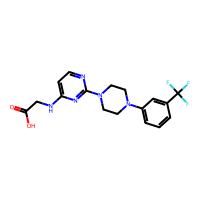
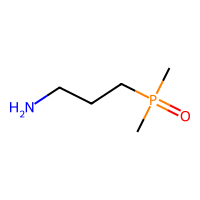
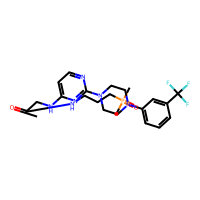
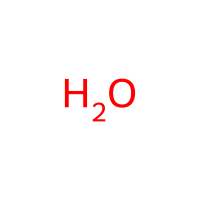
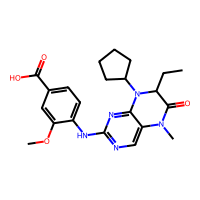
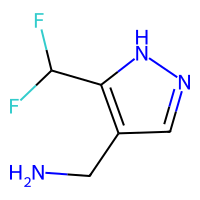
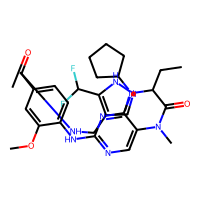
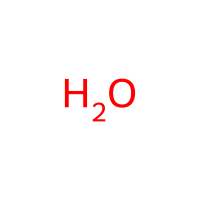
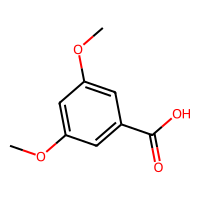
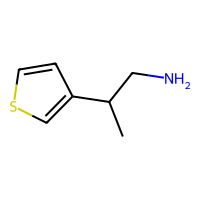
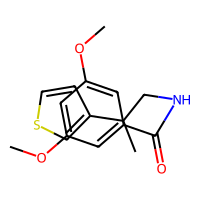
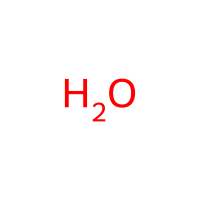
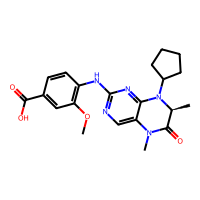
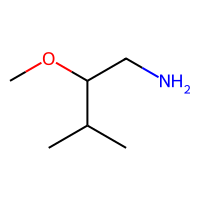
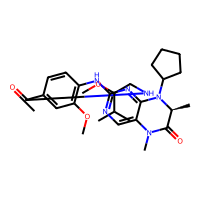
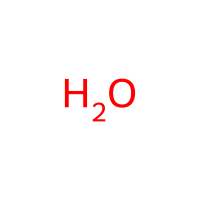

In [ ]:
### Reaction SMARTS for amidation
smarts_amidation = "[c,C:1][NH2:2].[C:3](=[O:4])[O:5]>>[c,C:1][NH:2]-[C:3]=[O:4].[O:5]"

### Amidation
amidation_df = pd_mol.rxn_2_sms(
    cross_merge_amides_df, smarts_amidation, mol_col_1="Mol_amine", mol_col_2="Mol_acid"
)

### Create product ID
amidation_df["ID"] = amidation_df["acid_ID"] + "_" + amidation_df["amine_ID"]
render_mol(amidation_df.sample(5))

**Slice for relevant columns**

,Mol
ID,
acid-62_amine-20,
acid-172_amine-5,
acid-188_amine-31,

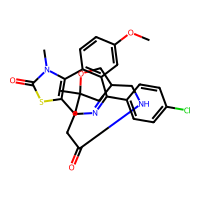
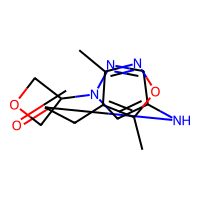
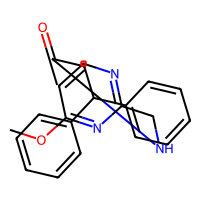

In [ ]:
comb_amides_df = pd.DataFrame()
comb_amides_df[["ID", "Mol"]] = copy.deepcopy(amidation_df[["ID", "Product_0"]])
comb_amides_df = comb_amides_df.set_index("ID")
render_mol(comb_amides_df.sample(3))

**Drop empty rows**

In [117]:
print(comb_amides_df.isna().sum())
comb_amides_df = comb_amides_df.dropna()

Mol    386
dtype: int64


**Structure standardization**

In [ ]:
# comb_amides_df['original_Mol'] = comb_amides_df['Mol']                # saves original 'Mol' column for inspection
comb_amides_df["Mol"] = pd_mol.standardize_mol_col(comb_amides_df["Mol"])

largest_frag=True (rdMolStandardize.FragmentParent):


100%|██████████| 9264/9264 [00:13<00:00, 666.04it/s]


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 9264/9264 [00:00<00:00, 12037.02it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 9264/9264 [00:08<00:00, 1127.34it/s]


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=True (rdDepictor.Compute2DCoords):


100%|██████████| 9264/9264 [00:04<00:00, 1901.41it/s]


cal_2D_coord_deep=False (rdCoordGen.AddCoords):
cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 9264/9264 [00:12<00:00, 752.40it/s]


9264


,Mol
ID,
acid-37_amine-42,
acid-157_amine-34,
acid-104_amine-28,
acid-11_amine-39,
acid-114_amine-25,

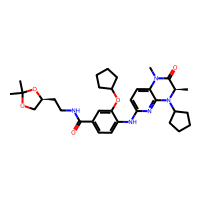
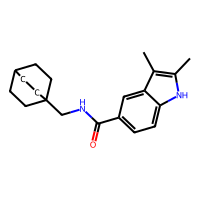
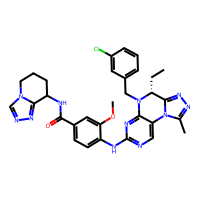
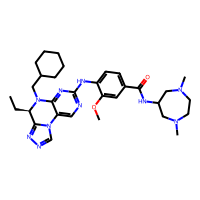
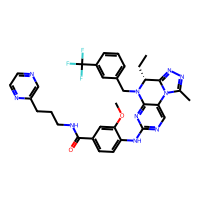

In [119]:
print(len(comb_amides_df))
render_mol(comb_amides_df.sample(5))

# Alkyne exit vector
## Alkynes
**Import from Enamine**

In [ ]:
alkynes_df = PandasTools.LoadSDF(
    "../data/Enamine_Acetylenes_5153cmpds_20240907.sdf", molColName="Mol"
)
len(alkynes_df)
render_mol(alkynes_df.head(2))

**Subset for terminal alkynes**

In [ ]:
condition_vector = alkynes_df["Subclass"].str.contains("Acetylenes_CH")
alkynes_df = alkynes_df.loc[condition_vector]

len(alkynes_df)

4156

**Assign alkyne IDs**

,Mw,ID,IUPAC Name,URL,Stock_weight_G,Class,Subclass,Mol,yne_ID
0,194.62,,2-chloro-N-(prop-2-yn-1-yl)pyridine-3-carboxamide,https://www.enaminestore.com/catalog/EN300-50409,28.99,Acetylenes,"Acetylenes, Acetylenes_CH",,yne-1
1,221.73,,"N-(prop-2-yn-1-yl)-1,2,3,4-tetrahydronaphthale...",https://www.enaminestore.com/catalog/EN300-50469,10.28,Acetylenes,"Acetylenes, Acetylenes_CH",,yne-2

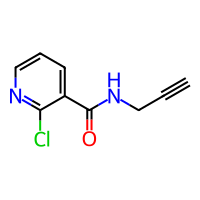
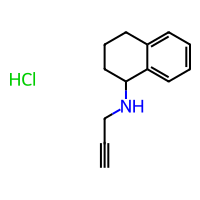

In [ ]:
alkynes_df = alkynes_df.reset_index(drop=True)
alkynes_df["yne_ID"] = alkynes_df.index.map(lambda x: f"yne-{x + 1}")
render_mol(alkynes_df.head(2))

**Subset for required columns**

In [ ]:
sm_alkynes_df = copy.deepcopy(alkynes_df[["yne_ID", "Mol"]])
sm_alkynes_df = sm_alkynes_df.set_index("yne_ID")

**Structure standardization**

largest_frag=True (rdMolStandardize.FragmentParent):


100%|██████████| 4156/4156 [00:04<00:00, 929.11it/s] 


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 4156/4156 [00:00<00:00, 22727.13it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 4156/4156 [00:02<00:00, 1538.21it/s]


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=True (rdDepictor.Compute2DCoords):


100%|██████████| 4156/4156 [00:00<00:00, 9774.40it/s] 


cal_2D_coord_deep=False (rdCoordGen.AddCoords):
cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 4156/4156 [00:04<00:00, 979.41it/s] 


,Mol
yne_ID,
yne-1,
yne-2,

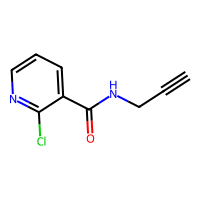
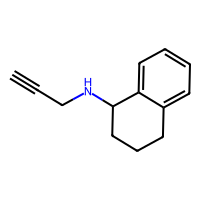

In [ ]:
sm_alkynes_df["Mol"] = pd_mol.standardize_mol_col(sm_alkynes_df["Mol"])
render_mol(sm_alkynes_df.head(2))

**Remove carbamates**
A lot of alkynes contain Boc-protected amines, probably for linker creation. In this case they are not relevant for us. 

In [ ]:
smart_cabamate = "[N][C](=[O])[O]"

filtered_alkynes_df = sm_alkynes_df.loc[
    pd_mol.count_smarts_matches(sm_alkynes_df, smart_cabamate) == 0
]
print(f"{len(sm_alkynes_df) - len(filtered_alkynes_df)} cabamates removed")
print(f"{len(filtered_alkynes_df)} alkynes left")

378 cabamates removed
3778 alkynes left


## Subset of Alkynes
Out of the 3.8 k alkynes a diversity set of 60 is chosen to stay within reasonable dimensions. 

**Morgan fingerprints**
Use the method `utils.similarity_sali.MorganSimilarity.get_morgan_fingerprint()` is used. 

In [ ]:
yne_morgan = MorganSimilarity(
    filtered_alkynes_df, radius=2, nBits=1024, useChirality=True
)
yne_Morgan_fingerprints = yne_morgan.get_morgan_fingerprint()

**MinMax Splitting**

In [ ]:
### Define diversity set size
set_size = 60

### Perform split
mmp = rd.SimDivFilters.MaxMinPicker()
yne_idx = mmp.LazyBitVectorPick(
    yne_Morgan_fingerprints,  # contain only molecular descriptors
    len(yne_Morgan_fingerprints),  # total number of molecules
    set_size,
)  # absolute diversity/training set size

In [ ]:
### yne_idx is a positional index for the diversity/training set
print(len(yne_idx))
type(yne_idx)

60


rdkit.rdBase._vecti

,Mol
yne_ID,
yne-4135,
yne-3135,

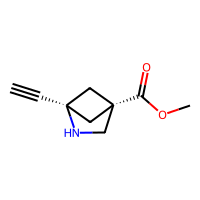
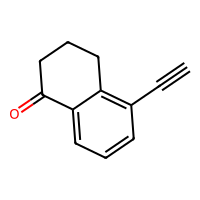

In [ ]:
### Using the bitvectors to subset for training data rows
diversity_set_alkynes_df = render_mol(filtered_alkynes_df.iloc[np.array(yne_idx)])
render_mol(diversity_set_alkynes_df.sample(2))

## Chloro exit vector

In [ ]:
chloro_df = copy.deepcopy(comb_amides_df)

**EDA**

In [ ]:
smarts_chloro = "[c:1][Cl:2]"

pd_mol.count_smarts_matches(chloro_df, smarts_chloro).value_counts()

Mol
0    7990
1    1251
2      23
Name: count, dtype: int64

**Subset combinatorial amide library for potential substrates**

Substrates with at least one aryl-chloro substituent are included. Compounds with multiple aryl-chloros will be reacted at one possible position. 

,Mol
ID,
acid-1_amine-43,
acid-2_amine-43,
acid-3_amine-1,

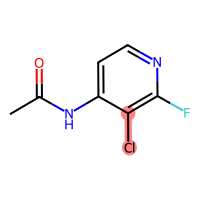
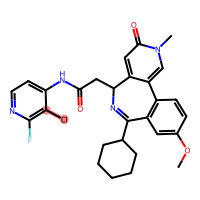
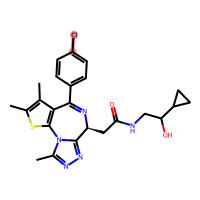

In [ ]:
sm_chloro_df = copy.deepcopy(
    chloro_df.loc[pd_mol.count_smarts_matches(chloro_df, smarts_chloro) != 0]
)
render_mol(sm_chloro_df.head(3))

## Combinatorial alkyne library
**SMARTS**

In [ ]:
rxn_smarts_sonogashira = "[c:1][Cl:2].[CH:3]#[C:4]>>[c:1][C:3]#[C:4].[Cl:2]"

**Cross-merge**

In [ ]:
### Resetting index columns
diversity_set_alkynes_df = diversity_set_alkynes_df.reset_index()
sm_chloro_df = sm_chloro_df.reset_index()

60 alkynes
1274 chlorides
76440 potential products


,yne_ID,Mol_yne,ID,Mol_chloro
19189,yne-1277,,acid-15_amine-19,
26490,yne-4142,,acid-163_amine-3,

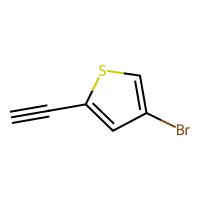
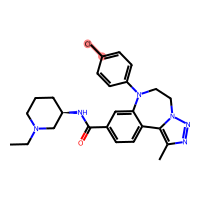
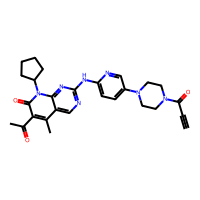
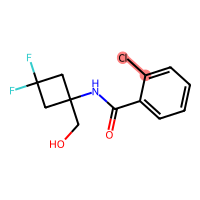

In [ ]:
cross_merge_yne_df = diversity_set_alkynes_df.merge(
    sm_chloro_df, how="cross", suffixes=["_yne", "_chloro"]
)

print("{} alkynes".format(len(diversity_set_alkynes_df)))
print("{} chlorides".format(len(sm_chloro_df)))
print("{} potential products".format(len(cross_merge_yne_df)))
render_mol(cross_merge_yne_df.sample(2))

**Virtual Sonogashira**

100%|██████████| 76440/76440 [00:17<00:00, 4368.83it/s]


,yne_ID,Mol_yne,ID,Mol_chloro,Product_0,Product_1
28908,yne-1752,,acid-124_amine-6_yne-1752_yne-1752,,,
70276,yne-3958,,acid-34_amine-33_yne-3958_yne-3958,,,
62447,yne-4068,,acid-3_amine-20_yne-4068_yne-4068,,,
6144,yne-2698,,acid-163_amine-41_yne-2698_yne-2698,,,
69143,yne-2721,,acid-62_amine-5_yne-2721_yne-2721,,,

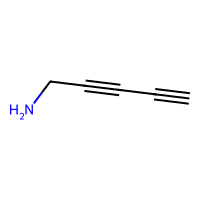
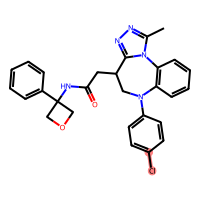
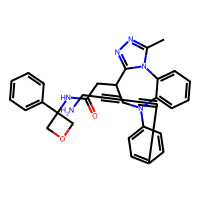
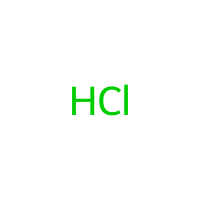
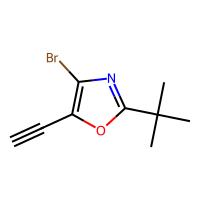
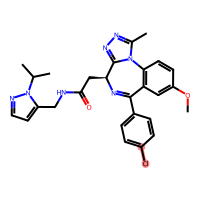
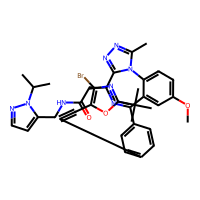
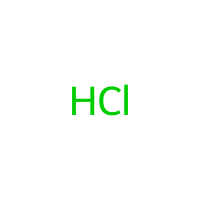
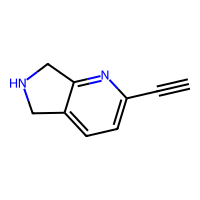
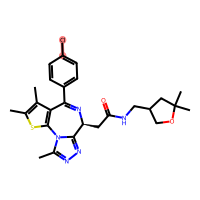
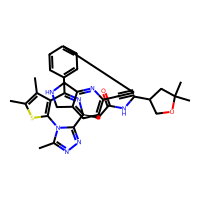
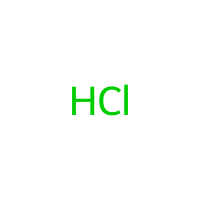
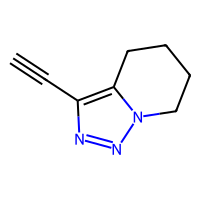
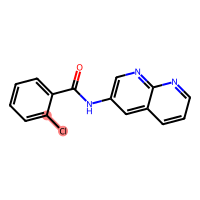
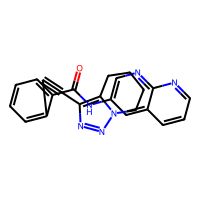
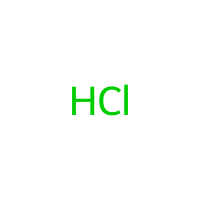
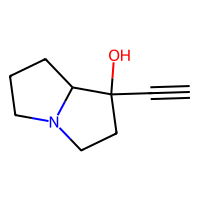
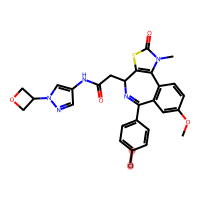
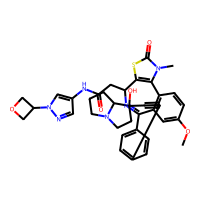
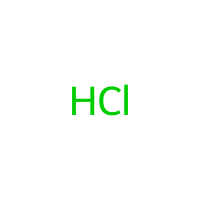

In [ ]:
### Virtual reaction
sonogashira_df = pd_mol.rxn_2_sms(
    cross_merge_yne_df,
    rxn_smarts_sonogashira,
    mol_col_1="Mol_chloro",
    mol_col_2="Mol_yne",
)

### Create product IDs
sonogashira_df["ID"] = sonogashira_df["ID"] + "_" + sonogashira_df["yne_ID"]
render_mol(sonogashira_df.sample(5))

**Slice for relevant columns**

In [ ]:
comb_ynes_df = pd.DataFrame()
comb_ynes_df[["ID", "Mol"]] = copy.deepcopy(sonogashira_df[["ID", "Product_0"]])
comb_ynes_df = comb_ynes_df.set_index("ID")

**Drop empty rows**

In [ ]:
comb_ynes_df.isna().sum()

Mol    0
dtype: int64

**Structure standardization**

`cal_2D_coord_deep=True` ensures the correct alkyne bond-angle of 180°. This step can take a multiple minutes.  

largest_frag=True (rdMolStandardize.FragmentParent):


  0%|          | 0/76440 [00:00<?, ?it/s]

100%|██████████| 76440/76440 [01:58<00:00, 647.52it/s]


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 76440/76440 [00:11<00:00, 6575.39it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 76440/76440 [01:32<00:00, 827.14it/s] 


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=not required (rdDepictor.Compute2DCoords):
cal_2D_coord_deep=True (rdCoordGen.AddCoords):


100%|██████████| 76440/76440 [33:05<00:00, 38.50it/s]  


cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 76440/76440 [01:54<00:00, 666.13it/s]


76440


,Mol
ID,
acid-1_amine-43_yne-1962_yne-1962,
acid-2_amine-43_yne-1962_yne-1962,
acid-3_amine-1_yne-1962_yne-1962,
acid-3_amine-2_yne-1962_yne-1962,
acid-3_amine-3_yne-1962_yne-1962,
...,...
acid-189_amine-48_yne-339_yne-339,
acid-190_amine-43_yne-339_yne-339,
acid-191_amine-43_yne-339_yne-339,

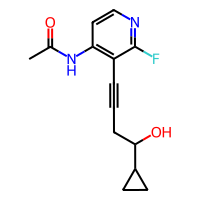
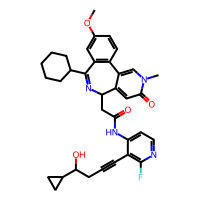
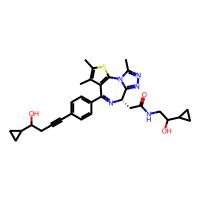
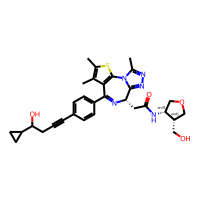
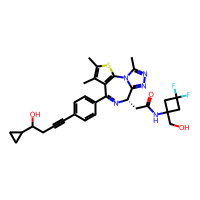
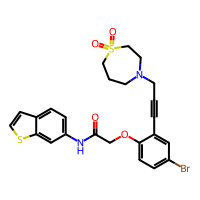
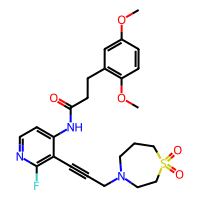
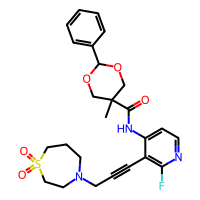
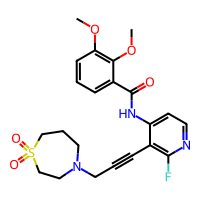
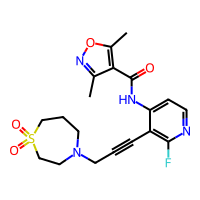

In [ ]:
comb_ynes_df["Mol"] = pd_mol.standardize_mol_col(
    comb_ynes_df["Mol"], cal_2D_coord_deep=True
)
print(len(comb_ynes_df))
render_mol(comb_ynes_df)

# Merge Amide and Alkyne Library

In [ ]:
comb_df = pd.concat([comb_amides_df, comb_ynes_df], axis=0)
print(len(comb_df))

85704


**Save combinatorial library**

In [ ]:
comb_df.to_pickle("../data/01_comb_amide_yne_library.pkl")